In [11]:
# Cell 1: Installation and imports (same as yours)
import operator
import requests
from typing import List, Dict, Any, Literal
from pydantic import BaseModel, Field
from langchain.prompts import PromptTemplate
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langgraph.graph import StateGraph, END
from langchain.output_parsers import PydanticOutputParser, OutputFixingParser
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from bs4 import BeautifulSoup
import os

# Set up environment
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"

# Initialize models
model = ChatGoogleGenerativeAI(model='gemini-1.5-flash')
embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en")


In [12]:
# Cell 2: Fixed Pydantic Models
class TopicSelectionParser(BaseModel):
    Topic: Literal["USA", "WEB_SEARCH", "GENERAL"] = Field(
        description="Selected topic from: USA, WEB_SEARCH, GENERAL"
    )
    Reasoning: str = Field(
        description="Reasoning behind topic selection",
        min_length=10
    )

class ValidationResult(BaseModel):
    is_valid: bool = Field(description="Whether the response is valid")
    confidence_score: float = Field(description="Confidence score between 0 and 1")
    issues: List[str] = Field(description="List of issues found if invalid", default=[])
    suggestion: str = Field(description="Suggestion for improvement if invalid", default="")

# Initialize parsers
topic_parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)
validation_parser = PydanticOutputParser(pydantic_object=ValidationResult)


In [13]:
# Cell 3: Agent State (same as yours)
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    current_step: str
    validation_attempts: int
    final_answer: str


In [14]:
# Cell 4: RAG Setup (same as yours)
loader = DirectoryLoader("../data2", glob="./*.txt", loader_cls=TextLoader)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=50
)
new_docs = text_splitter.split_documents(documents=docs)

db = Chroma.from_documents(new_docs, embeddings)
retriever = db.as_retriever(search_kwargs={"k": 3})

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


In [15]:
# Cell 5: Web Crawler (same as yours)
def web_crawler(query: str, max_results: int = 3) -> str:
    try:
        search_url = f"https://html.duckduckgo.com/html/?q={query.replace(' ', '+')}"
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
        }
        
        response = requests.get(search_url, headers=headers, timeout=10)
        soup = BeautifulSoup(response.content, 'html.parser')
        
        results = []
        result_elements = soup.find_all('div', class_='result')[:max_results]
        
        for element in result_elements:
            title_elem = element.find('a', class_='result__a')
            snippet_elem = element.find('div', class_='result__snippet')
            
            if title_elem and snippet_elem:
                title = title_elem.get_text(strip=True)
                snippet = snippet_elem.get_text(strip=True)
                results.append(f"Title: {title}\nContent: {snippet}")
        
        return "\n\n".join(results) if results else "No relevant information found online."
        
    except Exception as e:
        return f"Web search failed: {str(e)}"


In [16]:
# Cell 6: FIXED Node Functions
def supervisor_node(state: AgentState):
    """Classifies the query and determines the next step"""
    print("-> SUPERVISOR NODE ->")
    
    question = state["messages"][-1].content if hasattr(state["messages"][-1], 'content') else str(state["messages"][-1])
    
    # Enhanced prompt with clear JSON format requirements
    template = """You are a query classifier. Analyze the user query and classify it into exactly one category.

Categories:
- USA: Questions about United States (economy, politics, geography, culture, etc.)
- WEB_SEARCH: Questions requiring current/real-time information from internet
- GENERAL: General knowledge questions that can be answered without real-time data

User query: "{question}"

You MUST respond with a valid JSON object following this exact format:
{{"Topic": "one of: USA, WEB_SEARCH, or GENERAL", "Reasoning": "explain why you chose this category"}}

Examples:
- "What is the GDP of USA?" -> {{"Topic": "USA", "Reasoning": "This asks about US economic data"}}
- "What's the weather today?" -> {{"Topic": "WEB_SEARCH", "Reasoning": "This requires current weather information"}}
- "What is 2+2?" -> {{"Topic": "GENERAL", "Reasoning": "This is basic math that doesn't need real-time data"}}

Remember: Your response must be valid JSON that can be parsed."""
    
    prompt = PromptTemplate(
        template=template,
        input_variables=["question"]
    )
    
    # Create a fixing parser that can retry on errors
    fixing_parser = OutputFixingParser.from_llm(parser=topic_parser, llm=model)
    
    try:
        chain = prompt | model | topic_parser
        response = chain.invoke({"question": question})
    except Exception as e:
        print(f"Primary parsing failed: {e}")
        # Use fixing parser as fallback
        raw_output = (prompt | model).invoke({"question": question})
        response = fixing_parser.parse(raw_output.content)
    
    print(f"Classified as: {response.Topic}")
    print(f"Reasoning: {response.Reasoning}")
    
    return {
        "messages": [AIMessage(content=response.Topic)],
        "current_step": "classification"
    }

def rag_node(state: AgentState):
    """Handles USA-related queries using RAG"""
    print("-> RAG NODE ->")
    
    original_question = state["messages"][0].content if hasattr(state["messages"][0], 'content') else str(state["messages"][0])
    
    prompt = PromptTemplate(
        template="""You are an assistant for question-answering tasks about the USA. 
        Use the following pieces of retrieved context to answer the question. 
        If you don't know the answer, just say that you don't know. 
        Use three sentences maximum and keep the answer concise.
        
        Question: {question} 
        Context: {context} 
        Answer:""",
        input_variables=['context', 'question']
    )
    
    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
    )
    
    result = rag_chain.invoke(original_question)
    print(f"RAG Result: {result}")
    
    return {
        "messages": [AIMessage(content=result)],
        "current_step": "rag_complete"
    }

def llm_node(state: AgentState):
    """Handles general queries using LLM knowledge"""
    print("-> LLM NODE ->")
    
    original_question = state["messages"][0].content if hasattr(state["messages"][0], 'content') else str(state["messages"][0])
    
    complete_query = f"Answer the following question using your knowledge: {original_question}"
    response = model.invoke(complete_query)
    
    print(f"LLM Result: {response.content}")
    
    return {
        "messages": [AIMessage(content=response.content)],
        "current_step": "llm_complete"
    }

def web_crawler_node(state: AgentState):
    """Handles queries requiring real-time web information"""
    print("-> WEB CRAWLER NODE ->")
    
    original_question = state["messages"][0].content if hasattr(state["messages"][0], 'content') else str(state["messages"][0])
    
    web_info = web_crawler(original_question)
    
    synthesis_prompt = f"""
    Based on the following web search results, provide a comprehensive answer to the question: {original_question}
    
    Web Search Results:
    {web_info}
    
    Please provide a clear, concise answer based on the search results:
    """
    
    response = model.invoke(synthesis_prompt)
    print(f"Web Crawler Result: {response.content}")
    
    return {
        "messages": [AIMessage(content=response.content)],
        "current_step": "web_complete"
    }

def validation_node(state: AgentState):
    """Validates the generated response"""
    print("-> VALIDATION NODE ->")
    
    original_question = state["messages"][0].content if hasattr(state["messages"][0], 'content') else str(state["messages"][0])
    generated_answer = state["messages"][-1].content if hasattr(state["messages"][-1], 'content') else str(state["messages"][-1])
    
    validation_prompt = f"""
    You are a quality validator. Evaluate the following answer for the given question.
    
    Question: {original_question}
    Answer: {generated_answer}
    
    Evaluate based on:
    1. Relevance to the question
    2. Accuracy of information
    3. Completeness of the answer
    4. Clarity and coherence
    
    Provide a confidence score between 0 and 1, where:
    - 0.8-1.0: Excellent answer
    - 0.6-0.8: Good answer
    - 0.4-0.6: Acceptable answer
    - 0.0-0.4: Poor answer (needs improvement)
    
    Respond with valid JSON:
    {{"is_valid": true/false, "confidence_score": 0.0-1.0, "issues": ["list of issues if any"], "suggestion": "suggestion for improvement if needed"}}
    """
    
    fixing_parser = OutputFixingParser.from_llm(parser=validation_parser, llm=model)
    
    try:
        validation_result = validation_parser.parse(model.invoke(validation_prompt).content)
    except Exception as e:
        print(f"Validation parsing failed: {e}")
        validation_result = fixing_parser.parse(model.invoke(validation_prompt).content)
    
    print(f"Validation Result: Valid={validation_result.is_valid}, Score={validation_result.confidence_score}")
    
    current_attempts = state.get("validation_attempts", 0) + 1
    
    return {
        "messages": [AIMessage(content=f"Validation: {validation_result.is_valid}")],
        "current_step": "validation_complete",
        "validation_attempts": current_attempts,
        "final_answer": generated_answer if validation_result.is_valid else ""
    }

def final_output_node(state: AgentState):
    """Generates the final output"""
    print("-> FINAL OUTPUT NODE ->")
    
    final_answer = state.get("final_answer", "")
    if not final_answer:
        for msg in reversed(state["messages"]):
            if hasattr(msg, 'content') and msg.content not in ["USA", "WEB_SEARCH", "GENERAL"] and not msg.content.startswith("Validation:"):
                final_answer = msg.content
                break
    
    return {
        "messages": [AIMessage(content=f"FINAL ANSWER: {final_answer}")],
        "current_step": "complete"
    }


In [17]:
# Cell 7: Router Functions (same as yours)
def classification_router(state: AgentState):
    """Routes based on classification"""
    print("-> CLASSIFICATION ROUTER ->")
    
    last_message = state["messages"][-1].content if hasattr(state["messages"][-1], 'content') else str(state["messages"][-1])
    
    if "USA" in last_message:
        return "rag"
    elif "WEB_SEARCH" in last_message:
        return "web_crawler"
    else:
        return "llm"

def validation_router(state: AgentState):
    """Routes based on validation result"""
    print("-> VALIDATION ROUTER ->")
    
    last_message = state["messages"][-1].content if hasattr(state["messages"][-1], 'content') else str(state["messages"][-1])
    validation_attempts = state.get("validation_attempts", 0)
    
    if "Validation: True" in last_message:
        return "final_output"
    elif validation_attempts >= 2:
        print("Max validation attempts reached, proceeding to final output")
        return "final_output"
    else:
        print("Validation failed, returning to supervisor")
        return "supervisor"


In [18]:
# Cell 8: Build Graph (same as yours)
workflow = StateGraph(AgentState)

workflow.add_node("supervisor", supervisor_node)
workflow.add_node("rag", rag_node)
workflow.add_node("llm", llm_node)
workflow.add_node("web_crawler", web_crawler_node)
workflow.add_node("validation", validation_node)
workflow.add_node("final_output", final_output_node)

workflow.set_entry_point("supervisor")

workflow.add_conditional_edges(
    "supervisor",
    classification_router,
    {
        "rag": "rag",
        "llm": "llm",
        "web_crawler": "web_crawler"
    }
)

workflow.add_edge("rag", "validation")
workflow.add_edge("llm", "validation")
workflow.add_edge("web_crawler", "validation")

workflow.add_conditional_edges(
    "validation",
    validation_router,
    {
        "final_output": "final_output",
        "supervisor": "supervisor"
    }
)

workflow.add_edge("final_output", END)

app = workflow.compile()


In [19]:
# Cell 9: Test the Implementation
print("=== TEST 1: USA GDP Query ===")
state1 = {"messages": [HumanMessage(content="What is the GDP of USA?")], "validation_attempts": 0}
result1 = app.invoke(state1)
print(f"Final result: {result1['messages'][-1].content}\n")

print("=== TEST 2: General Query ===")
state2 = {"messages": [HumanMessage(content="What is the capital of France?")], "validation_attempts": 0}
result2 = app.invoke(state2)
print(f"Final result: {result2['messages'][-1].content}\n")

print("=== TEST 3: Current Information Query ===")
state3 = {"messages": [HumanMessage(content="What are the latest news about artificial intelligence?")], "validation_attempts": 0}
result3 = app.invoke(state3)
print(f"Final result: {result3['messages'][-1].content}\n")


=== TEST 1: USA GDP Query ===
-> SUPERVISOR NODE ->
Classified as: USA
Reasoning: This question asks for the Gross Domestic Product (GDP) of the United States, a key economic indicator of the country.
-> CLASSIFICATION ROUTER ->
-> RAG NODE ->
RAG Result: The nominal GDP of the USA is approximately $28 trillion USD as of 2024.  This represents about 25% of the global economy.  It holds the #1 ranking worldwide by nominal GDP.
-> VALIDATION NODE ->
Validation Result: Valid=True, Score=0.75
-> VALIDATION ROUTER ->
-> FINAL OUTPUT NODE ->
Final result: FINAL ANSWER: The nominal GDP of the USA is approximately $28 trillion USD as of 2024.  This represents about 25% of the global economy.  It holds the #1 ranking worldwide by nominal GDP.

=== TEST 2: General Query ===
-> SUPERVISOR NODE ->
Classified as: GENERAL
Reasoning: This is a general knowledge question about geography that can be answered from established facts, not requiring real-time information or specific data about the USA.
-> 

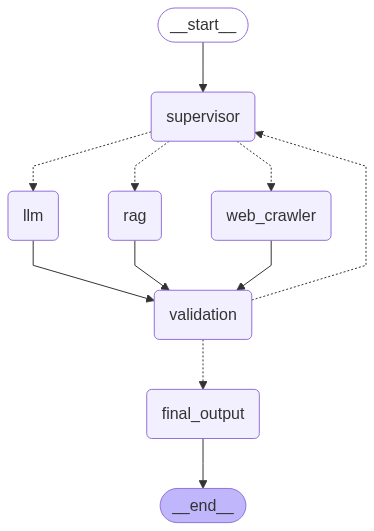

In [22]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))